# Учебная задача: Анализ сайта «СберАвтоподписка»

### Задача состоит в том, чтобы по визиту предсказать, будет ли совершенно целевое действие (Оставить заявку, Заказать звонок, Открыть диалог)

## Этап 1. Чтение, анализ и обработка данных

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
import optuna

import warnings
warnings.filterwarnings("ignore")

# Читаем данные о визитах
sessions = pd.read_csv("ga_sessions.csv", parse_dates=["visit_date"])

# Датасет с хитами тяжёлый, но нам нужны только колонки, обозначающие целевое действие. Прочитаем только их
hits = pd.read_csv("ga_hits.csv", usecols=["session_id", "event_category", "event_action"])

# Выводим первые строки, чтобы посмотреть содержимое
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


### Работа с датасетом `sessions`

Наш основной датасет - `sessions`. Сперва посмотрим на данные до какой - либо предобработки. **Все** поля кроме `visit_number` нечисловые. Статистические характеристики (среднее, стандартное отклонение, распределение) проанализировать невозможно. Поэтому оценим кол - во пропусков и уникальных значений в каждой колонке а так же определим наиболее часто встречающиеся группы

In [ ]:
# Определим кол - во пропущенных значений
print("Пропущено значений в столбце:")
for column in sessions.columns:
    print(f"· {column} -", str(round(sessions[column].isna().mean() * 100, 2)) + "%")

Пропущено значений в столбце:
· session_id - 0.0%
· client_id - 0.0%
· visit_date - 0.0%
· visit_time - 0.0%
· visit_number - 0.0%
· utm_source - 0.01%
· utm_medium - 0.0%
· utm_campaign - 11.81%
· utm_adcontent - 18.04%
· utm_keyword - 58.17%
· device_category - 0.0%
· device_os - 57.53%
· device_brand - 19.74%
· device_model - 99.12%
· device_screen_resolution - 0.0%
· device_browser - 0.0%
· geo_country - 0.0%
· geo_city - 0.0%


In [ ]:
# Посчитаем уникальные значения
print("Уникальных значений в столбце:")
for column in sessions.columns:
    print(f"· {column} -", sessions[column].nunique())

Уникальных значений в столбце:
· session_id - 1860042
· client_id - 1391717
· visit_date - 226
· visit_time - 85318
· visit_number - 537
· utm_source - 293
· utm_medium - 56
· utm_campaign - 412
· utm_adcontent - 286
· utm_keyword - 1219
· device_category - 3
· device_os - 13
· device_brand - 205
· device_model - 104
· device_screen_resolution - 5039
· device_browser - 57
· geo_country - 166
· geo_city - 2548


Посмотрим на группы в столбцах. Для каждого столбца выведем топ 10 значений, остальные относим к категории "Other". Напротив столбца "Other" дополнительно укажем сколько уникальных значений туда попало

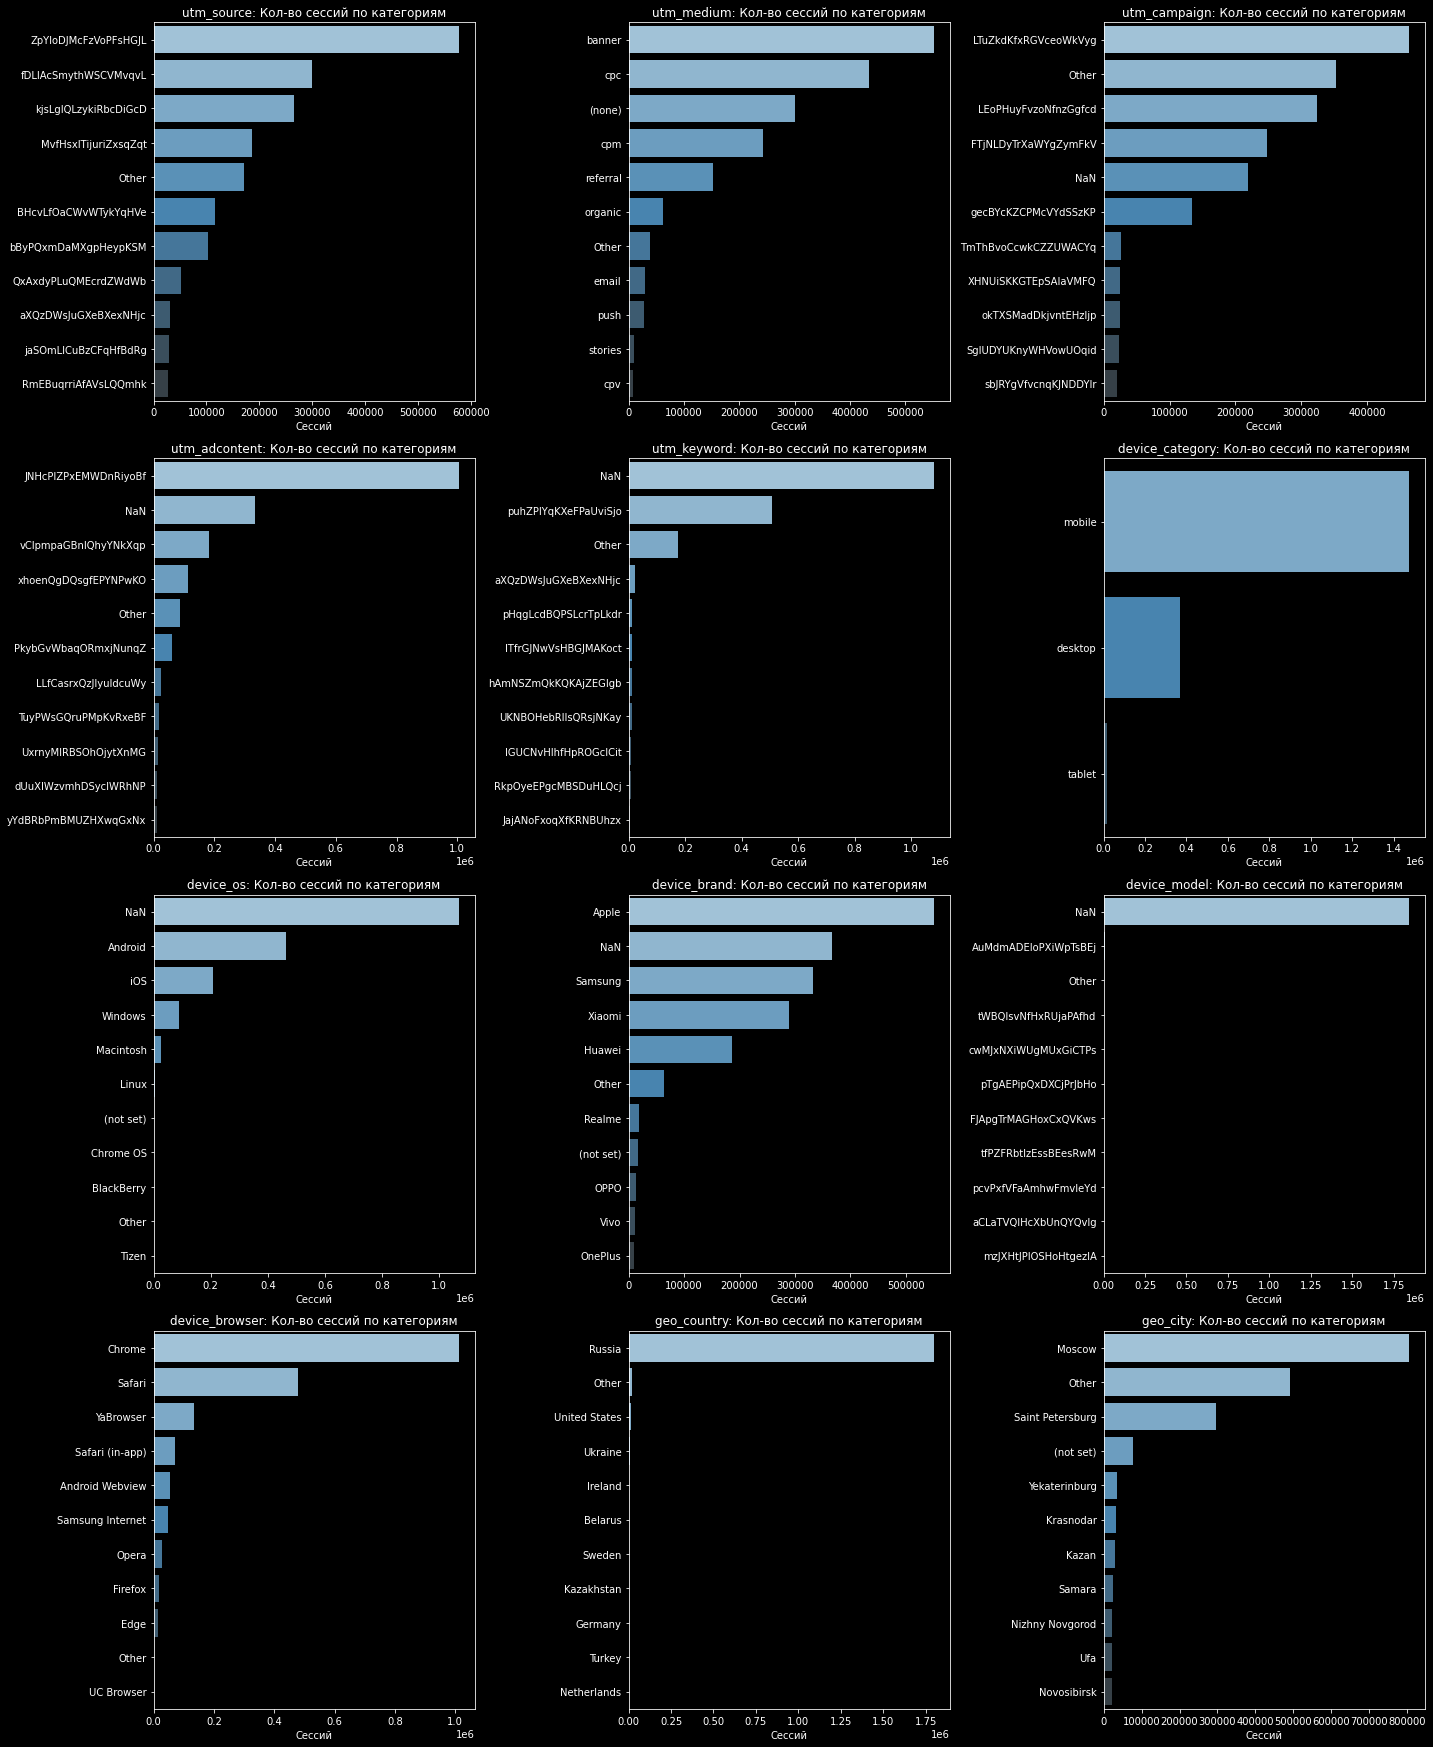

In [ ]:
# Напишем функцию, которая считает топ уникальных значений, а остальные собирает в Other
def group_top(df, col, top_n=10):
    # Находим топ n самых популярных значений
    temp_df = df[[col]].copy().fillna('NaN')
    top_values = temp_df[col].value_counts(dropna=False).nlargest(top_n).index

    # Заменяем значения вне топа на 'Other'
    grouped = temp_df[col].apply(lambda x: x if x in top_values else 'Other')

    # Группируем и считаем количество и число уникальных оригинальных значений
    result = temp_df.groupby(grouped).agg(
        count=(col, 'count'),
        unique_values=(col, 'nunique')
    ).reset_index().sort_values("count", ascending=False)

    return result

# Функция построения графиков
def draw_categories(df, columns_to_draw:list, top_n=10, plots_per_row=3):
    """
    Функция для отрисовки категориальных столбцов
    Первые top_n значений по кол - ву сессий выводятся на график.
    Остальные объединяются в Other
    Кол - во пустых значений выводится отдельно
    · df - DataFrame для анализа
    · columns_to_draw - список столбцов для отрисовки. Принимаются только категориальные
    · top_n - кол - во групп, которые выводить на график
    · plots_per_row - число графиков на одной горизонтали
    """
    # Число графиков = число колонок
    total_plots = len(columns_to_draw)
    # Сколько всего нужно горизонталей
    n_rows = total_plots // plots_per_row + 1

    # Рисуем сетку
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 6 * n_rows))
    # Обработка ошибки на случай, если рисуем только одну колонку
    axes = axes.reshape(n_rows, plots_per_row)

    for plot_idx, col in enumerate(columns_to_draw):
        result = group_top(df, col, top_n)
        group_col = result.columns[0]

        row = plot_idx // plots_per_row
        col_pos = plot_idx % plots_per_row
        ax = axes[row][col_pos]

        # График с количеством сессий на группу
        sns.barplot(
            data=result,
            y=group_col,
            x='count',
            ax=ax,
            palette='Blues_d'
        )
        ax.set_title(f'{col}: Кол-во сессий по категориям')
        ax.set_xlabel('Сессий')
        ax.set_ylabel('')

        # Добавим подпись количества уникальных значений только для 'Other'
        if 'Other' in result[group_col].values:
            other_row = result[result[group_col] == 'Other'].iloc[0]

            # Получаем текущие метки на оси Y
            yticklabels = [t.get_text() for t in ax.get_yticklabels()]
            y_index = yticklabels.index('Other')

            # Небольшое смещение подписи, чтоб не было наложения
            offset = 0.02 * result['count'].max()

            ax.text(
                other_row['count'] + offset,
                y_index,
                f"{other_row['unique_values']} уник.",
                va='center',
                ha='left',
                fontsize=11,
                color='black'
            )

    # Удалим пустые графики
    for i in range(total_plots, n_rows * plots_per_row):
        row = i // plots_per_row
        col = i % plots_per_row
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.show()

cols_to_draw = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
                'device_os', 'device_brand', 'device_model', 'device_browser', 'geo_country', 'geo_city']

draw_categories(sessions, cols_to_draw)

Какие выводы сейчас можем сделать:
- В ключеввых колонках `utm_source` (источник) и особенно `utm_medium` (канал) относительно немного уникальных значений. `utm_medium` точно не стоит преобразовывать и объединять каналы в более крупные категории. В случае с `utm_source` следует проанализировать их в паре с `utm_medium`. Вполне возможно, что у большинства каналов всего несколько источников, но есть канал с большим кол - вом уникальных источников и в таком случае часть `utm_source можно "схлопнуть"
- "Опциональные" utm метки (campaign, adcontent, keyword) стоит использовать аккуратно, например дать им малые веса либо не использовать вообще. Слишком много уникальных значений, при этом редко когда они сохраняются в будущем. Такие метки привязаны к определённым рекламным размещениям
- `device_os` и `device_brand` могут быть полезны, если мы обработаем пропуски. После чего сможем преобразовать оба столбца
- В колонке `device_browser` видно, что почти все визиты были с 5 - 6 наиболее популярных браузеров. Остальные ~50 браузеров можно объединить
- Почти все визиты из России. Остальные страны не очень нас интересуют, но можем попробовать сгруппировать их и поискать корреляции
- А вот города представлены очень разнообразно. Кроме Москвы и СПБ нет явных фаворитов. Здесь возможно оставим три группы: МСК, СПБ и остальные (либо не будем использовать этот столбец для предсказания вообще)  
  
Перейдём к обработке столбцов. Начнём с пропусков

Наиболее проблемное поле - `device_model`. В нём 99% пропущенных значений. С помощью других полей определить модель мы никак не можем. Исключим этот столбец из анализа  

In [ ]:
# Удаляем колонку device_model
sessions = sessions.drop(columns=["device_model"])

Много пропусков в колонке `utm_keyword`. Скорее всего, это значение поискового запроса при переходе по контекстной рекламе в поисковике. Но как мы помним этот столбец может нам понадобится в том виде, котором он есть сейчас. Оставим пока без изменений  
  
Так же много пустых значений в столбцах `device_os` и `device_brand`. Однако здесь есть взаимосвязь. Зная бренд устройства мы можем определить его OS, а так же для устройств на Windows, Linux и MacOS мы не знаем бренд, но точно можем сказать что это desktop устройство. Попробуем обработать эти колонки, заполнив пропуски

In [ ]:
# Для всех Desktop устройств указываем desktop в качестве бренда
sessions["device_brand"] = sessions["device_brand"].where(sessions['device_category'] != "desktop", 'desktop')

# Для каждого бренда определяем основную OS и сохраняем словарь
os_dict = sessions.groupby(["device_brand", "device_os"], as_index=False).size().sort_values(["device_brand", "size"], ascending=[True, False]) \
        .groupby(["device_brand"], as_index=False).first().drop(columns=["size"]).set_index('device_brand')['device_os'].to_dict()

# Заполняем пустые значения в колонке device_os основной OS для бренда
sessions['device_os'] = sessions['device_os'].fillna(sessions['device_brand'].map(os_dict))

# Посмотрим сколько осталось пропусков
print("Осталось пропущенных значений:", max(sessions['device_brand'].isna().sum(), sessions['device_os'].isna().sum()))
print("Заполним их случайными парами os + device_brand")

# Заполним случайными парами os + brand
missing_idx = sessions[(sessions['device_brand'].isna()) | (sessions['device_os'].isna())].index
values_to_refill = (
    sessions[(sessions['device_brand'].notna()) & (sessions['device_os'].notna())][["device_os", "device_brand"]]
    .sample(len(missing_idx), random_state=42)
    .reset_index(drop=True)
)

sessions.loc[missing_idx, ["device_os", "device_brand"]] = values_to_refill.values

Осталось пропущенных значений: 457
Заполним их случайными парами os + device_brand


Возможно вероятность конверсии зависит в том числе от разрешения экрана. Создадим ещё одно поле: коэффициент площади экрана в разрезе типа устройства. Для каждой записи найдём площадь экрана (кол - во пикселей) и разделим на среднюю площадь по всем аналогичным устройствам

In [ ]:
# Разделяем ширину и высоту экрана. Приводим к числовому типу
sessions[["screen_width", "screen_height"]] = pd.DataFrame(sessions["device_screen_resolution"].str.split('x').tolist()) \
                                                .apply(pd.to_numeric, errors='coerce').astype('Int64')
# Находим площадь устройства для каждой сессии
sessions["screen_area"] = sessions["screen_width"] * sessions["screen_height"]

# Считаем коэффициент площади
sessions["screen_area_coeff"] = round(sessions["screen_area"] / sessions.groupby(["device_category"])["screen_area"].transform('mean'), 2)

# При обучении модели выяснилось, что есть несколько NaN значений. Присвоим им 1
sessions["screen_area_coeff"] = sessions["screen_area_coeff"].fillna(1)

# Удаляем больше не нужные колонки
sessions = sessions.drop(columns=["device_screen_resolution", "screen_width", "screen_height", "screen_area"])

Перейдём к решению проблемы с большим кол - вом уникальных значений

Значения в столбцах `device_os`, `device_brand`, `device_browser`, `geo_country` и тем более `geo_city` стоит по возможности объединить. Так мы точно можем сгруппировать страны и города  
Страны разобьём на три категории:
1. Россия
2. Страны СНГ
3. Прочие

In [ ]:
# Отберём страны СНГ
sng_countries = {
    'Armenia', 'Azerbaijan', 'Belarus', 'Kazakhstan', 'Kyrgyzstan',
    'Moldova', 'Tajikistan', 'Turkmenistan', 'Uzbekistan', 'Ukraine'
}

def map_country(country):
    if country == 'Russia':
        return 'Russia'
    elif country in sng_countries:
        return 'SNG'
    else:
        return 'Other'

sessions["geo_country"] = sessions["geo_country"].apply(map_country)

Теперь классифицируем города: отдельно отберём Москву, Санкт - Петербург, миллионники и прочие населённые пункты

In [ ]:
# Список городов миллионников
millionaires = ["Yekaterinburg", "Krasnoyarsk", "Kazan", "Novosibirsk", "Nizhny Novgorod", "Ufa",
                "Chelyabinsk", "Tula", "Voronez", "Rostov-on-Don", "Omsk", "Perm", "Samara", "Volgograd"]

def map_city(city):
    if city in ('Moscow', 'Saint Petersburg'):
        return city
    elif city in millionaires:
        return 'Millonaries'
    else:
        return 'Other'
    
sessions["geo_city"] = sessions["geo_city"].apply(map_city)

Визитов с tablet (планшетов) было мало, поэтому будем считать их визитами с mobile и создадим колонку `is_mobile`

In [ ]:
sessions["is_mobile"] = sessions["device_category"].apply(lambda x: int(x != 'desktop'))
# Удалим ненужную колонку
sessions = sessions.drop(columns=["device_category"])

Оставим 5 наиболее популярные OS, бренд и браузер, остальные объединим  
Такое количество обусловлено тем, что на первые пять значений в каждом столбце приходится >90% сессий

In [ ]:
for col in ["device_os", "device_brand", "device_browser"]:
    if col == 'device_brand': 
        # Для бренда получим 6 категорий, т.к. одно место занимает desktop
        top_values = sessions[col].value_counts().head(6).index
    else:
        top_values = sessions[col].value_counts().head(5).index
    sessions[col] = sessions[col].where(sessions[col].isin(top_values), 'Other')

Теперь преобразуем дату и время визита. Точная дата и время нам ничего не дадут, но корреляции могут быть с месяцем днём недели или с часом визита. Создадим новые колонки

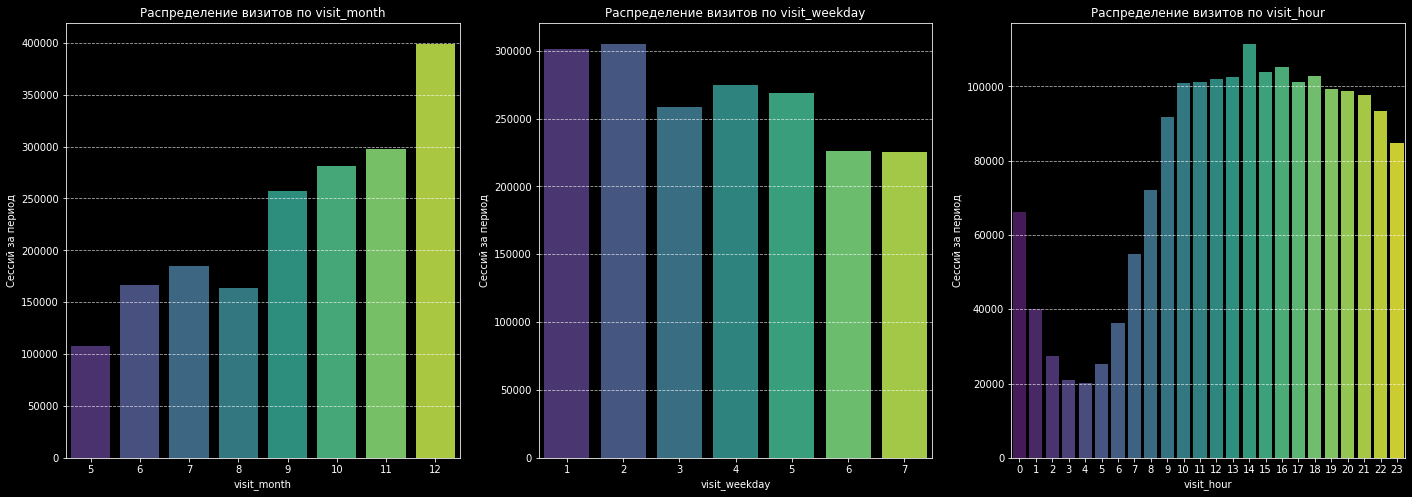

In [ ]:
sessions['visit_month'] = pd.to_datetime(sessions['visit_date']).dt.month
sessions['visit_hour'] = pd.to_datetime(sessions['visit_time'], format='%H:%M:%S').dt.hour
sessions['visit_weekday'] = sessions['visit_date'].dt.dayofweek + 1
sessions = sessions.drop(columns=["visit_date", "visit_time"])

# Построим распределение визитов по времени
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
axes = axes.reshape(1, 3)
for plot_idx, col in enumerate(["visit_month", "visit_weekday", "visit_hour"]):

    ax = axes[0][plot_idx]
    sns.countplot(x=sessions[col], palette='viridis', ax=ax)
    ax.set_title(f'Распределение визитов по {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("Сессий за период")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Итак, повторно посмотрим на наши колонки после преобразования

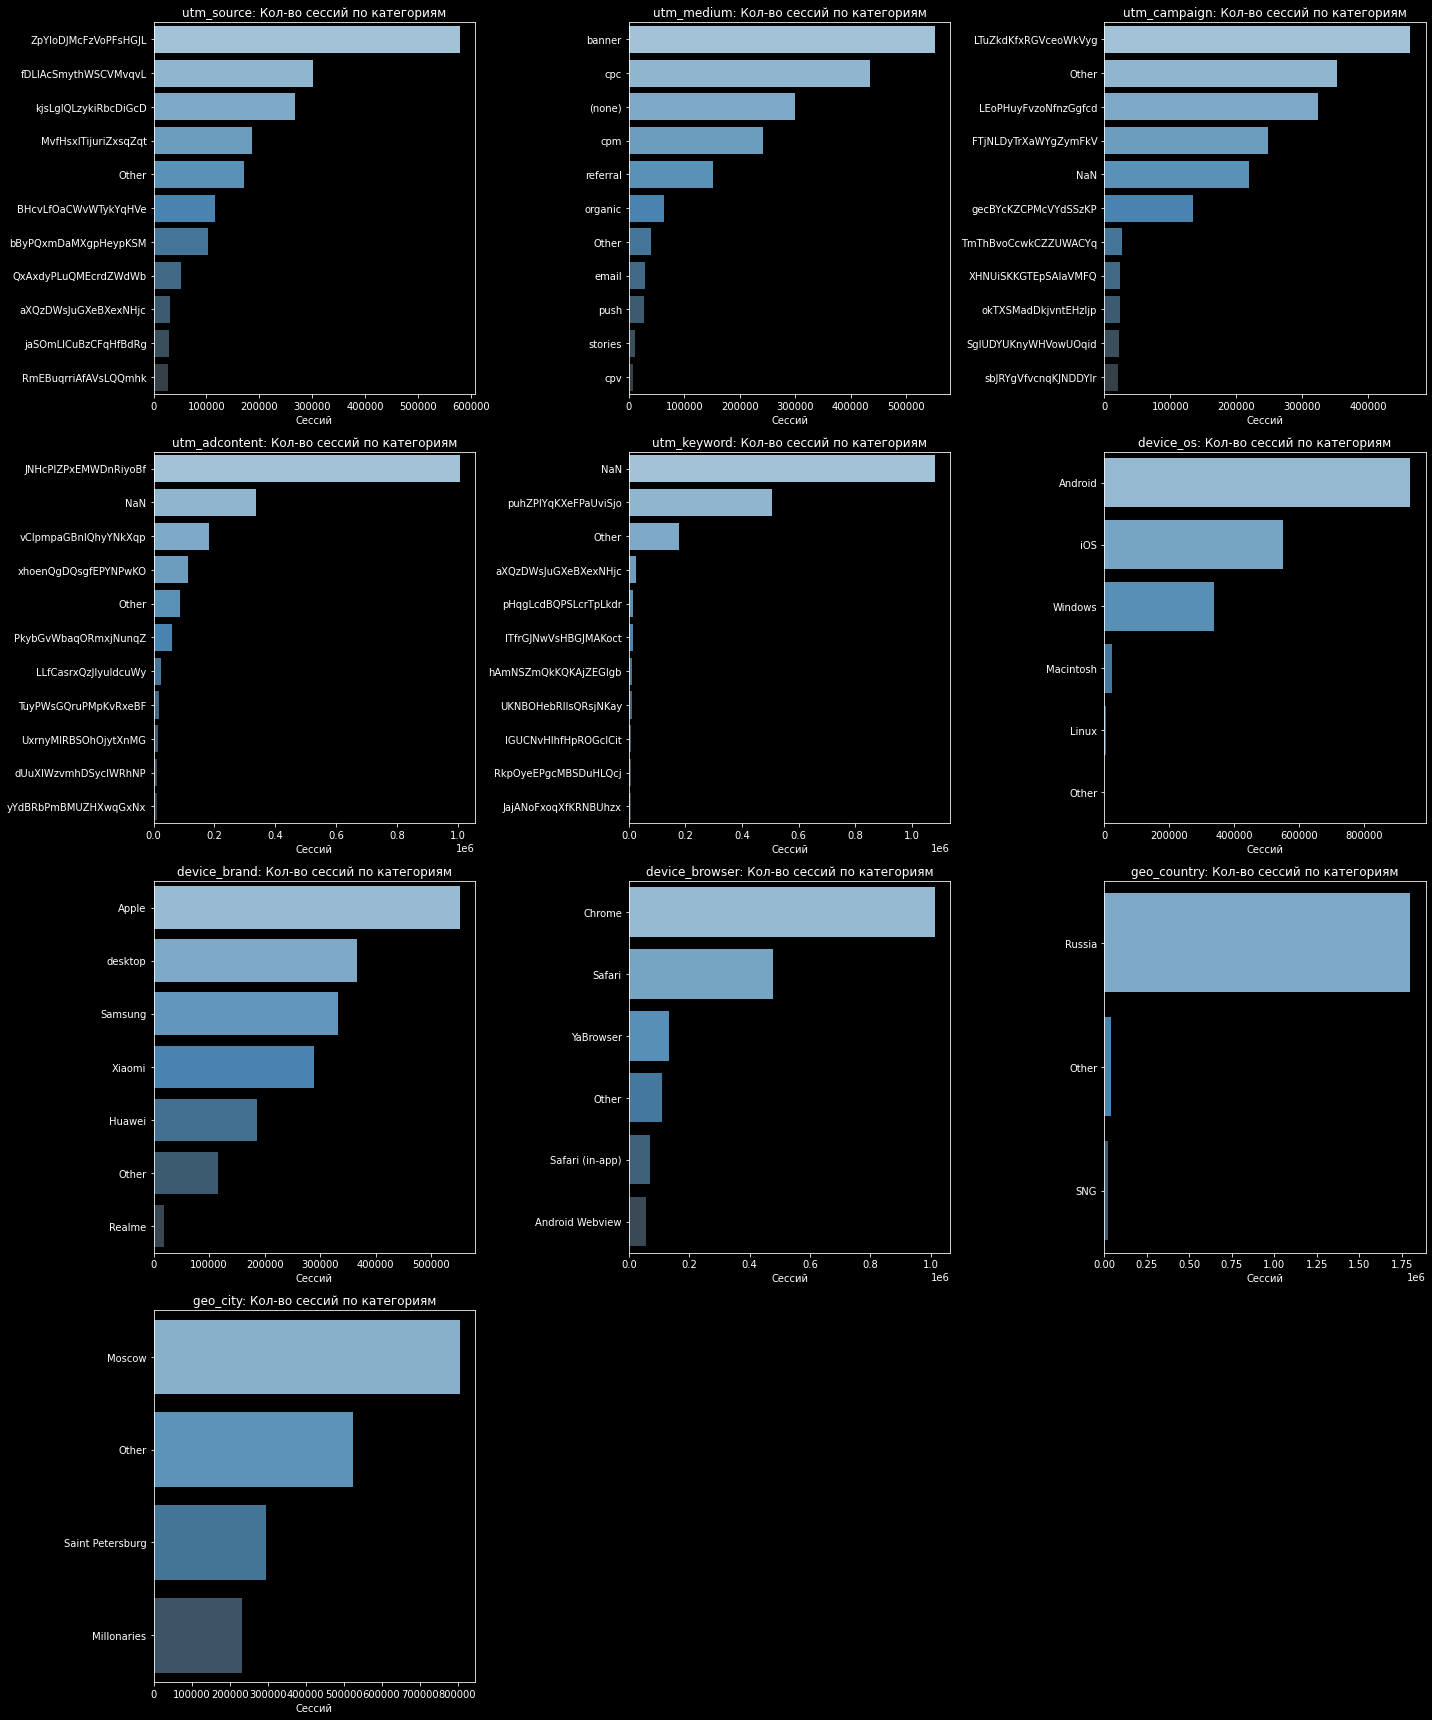

In [ ]:
cols_to_draw = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
                'device_os', 'device_brand', 'device_browser', 'geo_country', 'geo_city']

draw_categories(sessions, cols_to_draw)

У нас всё ещё есть пустые строки в колонках с utm метками. Удалять их нельзя и заполнить чем либо тоже. Поэтому преобразуем в строку, т.к. для модели не стоит использовать фичи с NaN значениями

In [ ]:
sessions = sessions.fillna('NaN')

### Работа с датасетом `hits`

Необходимо оставить только события, соответствующие целевому действию. Прочие записи можем удалить, они не потребуются для обучения модели  
Но для этого сперва посмотрим на список существующих событий и определим:  
1. Какого уровня детализации нам достаточно: до `event_category` или до `event_action`  
2. Какие события подходят под определение "целевого действия", 

In [ ]:
# Запишем все возможные сочетания в xlsx файл, чтобы в нём отобрать нужные category или action
hits.groupby(["event_category", "event_action"], as_index=False).size().to_excel("cat_and_act_list.xlsx", index=False)

Анализ сочетаний `event_category + event_action` показал, что целевые действия находятся во второй колонке. Составили следующий список:  
- `phone_auth_success|code_sms_entered_success|sber_id_auth_success` (авторизация на сайте)
- `success_ad_creation` (успешно созданное объявление)
- `user_message` (пользователь написал в чат)
- `greenday_sub_submit_success` (успешная заявка)
- `sub_submit_success` (успешная заявка)
- `chat requested` (запрос на создание чата)
- `user gave contacts during chat` (пользователь оставил контакты в чате)
- `sub_open_dialog_click` (открытие диалога при выборе подписки)
- `sub_callback_submit_click` (клик на запрос на обратного звонка)
- `form_request_call_sent` (запрос на обратный звонок)
- `sub_car_request_submit_click` (запрос на автоподписку)
- `click_buy_auto` (клик на купить авто)

Отфильтруем hits

In [ ]:
# Составляем словарь целевых действий

target_events = [
  'chat established',
  'mobile call','tap_on_phone_800','tap_on_phone_495','click_on_phone',
  'sub_submit_success','greenday_sub_submit_success','request_success',
  'sub_car_request_submit_click','sub_car_claim_submit_click',
  'sub_callback_submit_click','greenday_sub_callback_submit_click',
  'sub_custom_question_submit_click','form_request_call_sent',
]

# Оставляем только целевые действий
target_hits = hits[hits["event_action"].isin(target_events)].copy()

# Удаляем ненужные колонки и дублирующиеся сессии (если было несколко target_events)
target_hits = target_hits.drop(columns=["event_category", "event_action"])
target_hits = target_hits.drop_duplicates()

# Добавляем флаг цд
target_hits["target"] = 1

Формируем финальный датасет для обучения модели

In [ ]:
df = sessions.merge(target_hits, on=["session_id"], how="left")
df["target"] = df["target"].fillna(0)
df

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_os,device_brand,device_browser,geo_country,geo_city,screen_area_coeff,is_mobile,visit_month,visit_hour,visit_weekday,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,Android,Huawei,Chrome,Russia,Other,0.78,1,11,14,3,0.0
1,905544597018549464.1636867290.1636867290,210838531.163687,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,Android,Samsung,Other,Russia,Moscow,0.99,1,11,8,7,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,Android,Huawei,Chrome,Russia,Millonaries,0.78,1,12,2,2,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,Android,Xiaomi,Chrome,Russia,Moscow,0.93,1,5,5,6,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,Android,Xiaomi,Chrome,Russia,Moscow,0.93,1,5,5,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.164016,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,Windows,desktop,Chrome,Russia,Moscow,1.2,0,12,10,3,0.0
1860038,9055421130527858185.1622007305.1622007305,2108379530.162201,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,iOS,Apple,Safari,Russia,Other,0.99,1,5,8,3,0.0
1860039,9055422955903931195.1636979515.1636979515,2108379955.163697,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,iOS,Apple,Safari,Russia,Moscow,0.76,1,11,15,1,0.0
1860040,905543020766873816.1638189404.1638189404,210838164.163819,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,Android,Xiaomi,Chrome,Russia,Millonaries,1.01,1,11,15,1,0.0
